In [1]:
using JuMP, CPLEX, LinearAlgebra, DelimitedFiles, Plots, LinA
mc = readdlm("mcSmashWiki2.csv", ';', Float64)
mc= round.(mc, digits=2)
usage = [readdlm("communityDistribution.csv", ',', Float64)...];

In [20]:


function LearningCurveUsage(time)
    σ(x) = 1 /(1 + exp(-3x))
    peachLR(x) = 2σ(2x*time)-1
    restLR(x) = 2σ(x*time)-1


    restLRLin = Linearize(restLR,0,1,Relative(1))
    nbpieceRest = length(restLRLin)


    peachLRLin = Linearize(peachLR,0,1,Relative(1))
    nbpiecePeach = length(peachLRLin)



    model = Model(CPLEX.Optimizer)
    MOI.set(model, MOI.Silent(), true)
    @variable model x[1:26] >= 0


    @variable model active[1:26,1:nbpieceRest] binary = true
    @variable model f[1:26,1:nbpieceRest] >= 0

    @variable model activePeach[1:nbpiecePeach] binary = true
    @variable model fPeach[1:nbpiecePeach] >= 0

    #only one piece has weight
    for i in 1:26
        i == 13 && continue 
        @constraint model sum(active[i,:]) <= 1
    end
    #Same but for peach
    @constraint model sum(activePeach) <= 1

    #binding piece with activation
    for i=1:26,j=1:nbpieceRest
        i == 13 && continue

        @constraint model f[i,j] - restLRLin[j].xMin*active[i,j] >= 0
        @constraint model f[i,j] - restLRLin[j].xMax*active[i,j] <= 0
    end

    #Same but for peach
    for j in 1:nbpiecePeach

        @constraint model fPeach[j] - peachLRLin[j].xMin*activePeach[j] >= 0
        @constraint model fPeach[j] - peachLRLin[j].xMax*activePeach[j] <= 0
    end

    #constraint probability distribution

    @constraint model sum(f) + sum(fPeach) == 1

    #function to optimize
    α = 0
    for i=1:26,j=1:nbpieceRest 
        i == 13 && continue
        α += (mc*usage)[i]*(restLRLin[j].a*f[i,j] + restLRLin[j].b*active[i,j])
    end

    for j in 1: nbpiecePeach

        α += (mc*usage)[13]*(peachLRLin[j].a*fPeach[j] + peachLRLin[j].b*activePeach[j])    
    end

    @objective model Max α

    optimize!(model)

    playrates = sum(value.(f),dims=2)
    playrates[13] += sum(value.(fPeach))

    playrates
end

LearningCurveUsage (generic function with 1 method)

In [25]:
times = [0.1,0.2,1,15]
playrates = LearningCurveUsage.(times)

4-element Array{Array{Float64,2},1}:
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]
 [0.0; 0.0; … ; 0.0; 0.0]

In [27]:
p = bar.(playrates,legend=false,ylabel="Utilisation %")


4-element Array{Plots.Plot{Plots.GRBackend},1}:
 Plot{Plots.GRBackend() n=1}
 Plot{Plots.GRBackend() n=1}
 Plot{Plots.GRBackend() n=1}
 Plot{Plots.GRBackend() n=1}

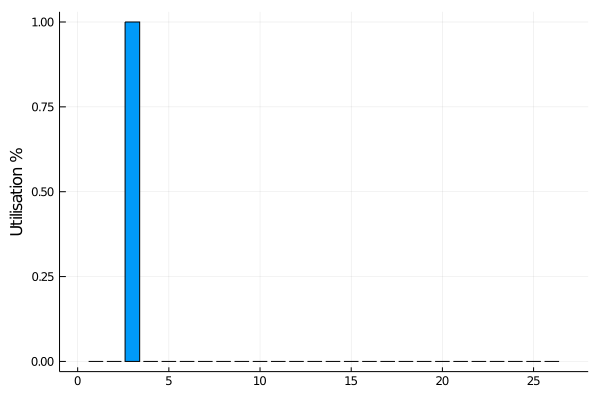

In [35]:
p[4]

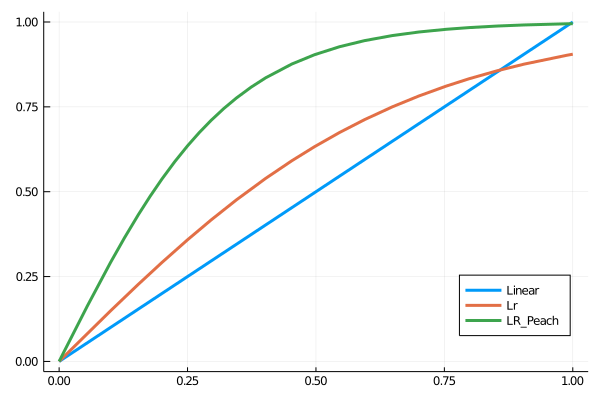

In [19]:

plot([x->x restLR peachLR],0,1,label=["Linear" "Lr" "LR_Peach"],legend=:bottomright,lw = 3)

In [74]:
plot([x->restLRLin(x) x->x],0,1,label=["LrLin" "Linear"],lw = 3,legend=:bottomright)

<!DOCTYPE html>
 
 
 Plots.jl